unicode_minus = False
Peclet number: 50000.00
Damköhler number: 2.00

초기값 1 시도: 지수적 감소
iter  0: residual = 2.908030e+00
         step size = 1.000000, new residual = 4.607641e-13
iter  1: residual = 4.607641e-13
✓ 수렴 완료! 최종 잔차: 4.607641e-13
최종 잔차: 4.607641e-13

초기값 2 시도: 선형 감소
iter  0: residual = 5.774080e+01
         step size = 1.000000, new residual = 1.027053e-11
iter  1: residual = 1.027053e-11
✓ 수렴 완료! 최종 잔차: 1.027053e-11
최종 잔차: 1.027053e-11

초기값 3 시도: 급한 지수
iter  0: residual = 2.908030e+00
         step size = 1.000000, new residual = 4.607641e-13
iter  1: residual = 4.607641e-13
✓ 수렴 완료! 최종 잔차: 4.607641e-13
최종 잔차: 4.607641e-13

초기값 4 시도: 포물선
iter  0: residual = 1.213807e+02
         step size = 1.000000, new residual = 2.697892e-11
iter  1: residual = 2.697892e-11
✓ 수렴 완료! 최종 잔차: 2.697892e-11
최종 잔차: 2.697892e-11

최적 결과: 지수적 감소
최종 잔차: 4.607641e-13
총 반복: 2
입구 농도: 10.000000
출구 농도: 1.408098


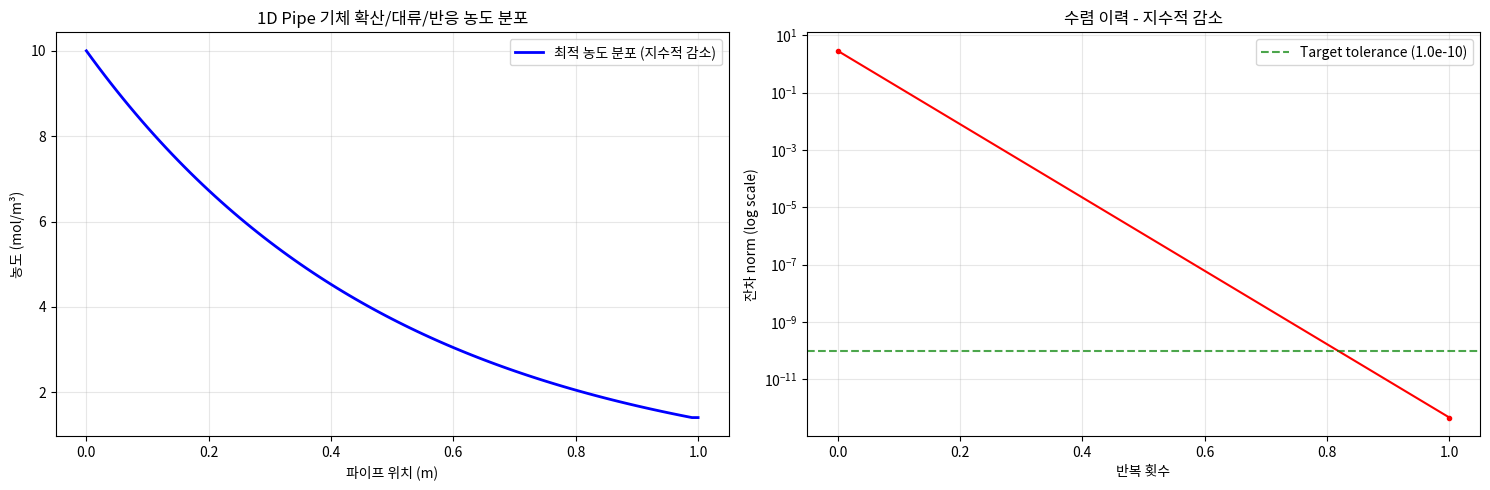


물리적 검증:
질량 수지 오차: 6.748064e-04
최종 수렴률: 0.000000


In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib
print("unicode_minus =", matplotlib.rcParams['axes.unicode_minus'])
# 더 높은 정밀도 사용
torch.set_default_dtype(torch.float64)

# 파이프 및 기체 확산 조건
L = 1.0  # 파이프 길이 (m)
D = 0.01  # 파이프 지름 (m)
A = torch.pi * (D/2)**2  # 단면적 (m^2)
N = 100  # 구간 개수
dx = L / N  # 각 구간의 길이 (m)
u = 1  # 유속 (m/s)
D_gas = 2e-5  # 기체 확산계수 (m^2/s)

# 반응 계수 (예: 1차 반응, -r = k*c)
k = 2.0  # 1/s, 반응속도상수 (원하는 값으로 조정)

# 경계 조건: 입구 농도 c_in, 출구에서 ddx=0 (Neumann)
c_in = 10.0  # 입구 농도 (예: mol/m^3)

# 무차원수 계산
Pe = u * L / D_gas  # Peclet number
Da = k * L / u      # Damköhler number
print(f"Peclet number: {Pe:.2f}")
print(f"Damköhler number: {Da:.2f}")

# 잔차 함수: 1D 정상상태 대류-확산-반응 방정식 + Neumann (출구)
def diffusion_reaction_residual_neumann(c, u, D_gas, dx, k):
    # c: torch.tensor, shape=[N+1], requires_grad=True
    residuals = []
    # 내부 노드 (1~N-1)
    for i in range(1, N):
        diff_term = D_gas * (c[i-1] - 2*c[i] + c[i+1]) / dx**2
        conv_term = u * (c[i] - c[i-1]) / dx
        react_term = -k * c[i]
        residuals.append(diff_term - conv_term + react_term)
    # 입구 Dirichlet 경계조건 (c[0] = c_in)
    residuals.insert(0, c[0] - c_in)
    # 출구 Neumann 경계조건 (dc/dx = 0 → c_N - c_{N-1} = 0)
    residuals.append((c[N] - c[N-1]) / dx)
    return torch.stack(residuals)

def line_search_backtrack(c, delta_c, current_res_norm, u, D_gas, dx, k, 
                         alpha_init=1.0, rho=0.5, c1=1e-4, max_iter=10):
    """
    Backtracking line search to ensure residual reduction
    """
    alpha = alpha_init
    
    for i in range(max_iter):
        # 새로운 해 시도
        c_new = c + alpha * delta_c
        
        # 물리적 제약: 농도는 0 이상이어야 함
        if torch.any(c_new < 0):
            alpha *= rho
            continue
        
        # 새로운 잔차 계산
        try:
            with torch.no_grad():
                c_new_grad = c_new.clone().detach().requires_grad_(True)
                res_new = diffusion_reaction_residual_neumann(c_new_grad, u, D_gas, dx, k)
                res_norm_new = res_new.norm().item()
            
            # Armijo 조건 체크 (충분한 감소)
            if res_norm_new < current_res_norm * (1 - c1 * alpha):
                return alpha, res_norm_new, True
                
        except:
            pass
        
        # step size 감소
        alpha *= rho
    
    return alpha, current_res_norm, False  # line search 실패

# 더 나은 초기 농도 분포 설정 (물리적으로 합리적인 지수 감소)
x = torch.linspace(0, L, N+1)

# 여러 초기값 시도
initial_guesses = [
    c_in * torch.exp(-Da * x / L),  # 지수적 감소 (반응 고려)
    c_in * (1 - x / L),  # 선형 감소
    c_in * torch.exp(-2 * x / L),  # 더 급한 지수 감소
    c_in * (1 - (x / L)**2),  # 포물선 감소
]

best_result = None
best_residual = float('inf')

for idx, c_init in enumerate(initial_guesses):
    print(f"\n{'='*50}")
    print(f"초기값 {idx+1} 시도: {['지수적 감소', '선형 감소', '급한 지수', '포물선'][idx]}")
    print(f"{'='*50}")
    
    c = c_init.clone().detach().requires_grad_(True)
    
    # Newton-Raphson 반복
    max_iter = 100
    tol = 1e-10
    
    convergence_history = []
    
    for it in range(max_iter):
        res = diffusion_reaction_residual_neumann(c, u, D_gas, dx, k)
        res_norm = res.norm().item()
        convergence_history.append(res_norm)
        
        if it % 10 == 0 or it < 5:
            print(f"iter {it:2d}: residual = {res_norm:.6e}")
        
        if res_norm < tol:
            print(f"✓ 수렴 완료! 최종 잔차: {res_norm:.6e}")
            break
        
        # Jacobian 계산
        try:
            jac = torch.autograd.functional.jacobian(
                lambda x: diffusion_reaction_residual_neumann(x, u, D_gas, dx, k), c
            )
            
            # Jacobian regularization (조건수 개선)
            reg_param = 1e-12
            jac_reg = jac + reg_param * torch.eye(jac.shape[0], dtype=jac.dtype)
            
            res_reduced = res.detach()
            delta_c = torch.linalg.solve(jac_reg, -res_reduced)
            
        except RuntimeError as e:
            print(f"Jacobian 문제 발생: {e}")
            break
        
        # Line search 적용
        alpha, new_res_norm, success = line_search_backtrack(
            c.detach(), delta_c, res_norm, u, D_gas, dx, k
        )
        
        if not success:
            print(f"Line search 실패 at iteration {it}")
            break
        
        # 해 업데이트
        with torch.no_grad():
            c = (c + alpha * delta_c).detach().requires_grad_(True)
        
        if it % 10 == 0 or it < 5:
            print(f"         step size = {alpha:.6f}, new residual = {new_res_norm:.6e}")
        
        # 정체 감지
        if it > 5 and len(convergence_history) >= 3:
            recent_improvement = convergence_history[-3] / convergence_history[-1]
            if recent_improvement < 1.01:  # 거의 개선이 없음
                print(f"수렴 정체 감지 (개선률: {recent_improvement:.6f})")
                break
    
    final_residual = convergence_history[-1] if convergence_history else float('inf')
    print(f"최종 잔차: {final_residual:.6e}")
    
    # 최적 결과 저장
    if final_residual < best_residual:
        best_residual = final_residual
        best_result = {
            'c': c.detach().clone(),
            'history': convergence_history,
            'initial_type': ['지수적 감소', '선형 감소', '급한 지수', '포물선'][idx],
            'iterations': it + 1
        }

# 최적 결과 출력
print(f"\n{'='*60}")
print(f"최적 결과: {best_result['initial_type']}")
print(f"최종 잔차: {best_residual:.6e}")
print(f"총 반복: {best_result['iterations']}")
print(f"입구 농도: {best_result['c'][0].item():.6f}")
print(f"출구 농도: {best_result['c'][-1].item():.6f}")

# 결과 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 농도 분포
ax1.plot(x.numpy(), best_result['c'].numpy(), 'b-', linewidth=2, 
         label=f'최적 농도 분포 ({best_result["initial_type"]})')
ax1.set_xlabel('파이프 위치 (m)')
ax1.set_ylabel('농도 (mol/m³)')
ax1.set_title('1D Pipe 기체 확산/대류/반응 농도 분포')
ax1.grid(True, alpha=0.3)
ax1.legend()

# 수렴 이력
iterations = range(len(best_result['history']))
ax2.semilogy(iterations, best_result['history'], 'r-o', markersize=3, linewidth=1.5)
ax2.axhline(y=tol, color='g', linestyle='--', alpha=0.7, label=f'Target tolerance ({tol:.1e})')
ax2.set_xlabel('반복 횟수')
ax2.set_ylabel('잔차 norm (log scale)')
ax2.set_title(f'수렴 이력 - {best_result["initial_type"]}')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# 물리적 검증
mass_balance_error = abs(best_result['c'][0] * u * A - best_result['c'][-1] * u * A)
print(f"\n물리적 검증:")
print(f"질량 수지 오차: {mass_balance_error:.6e}")

# 수렴률 분석
if len(best_result['history']) > 1:
    final_rate = best_result['history'][-1] / best_result['history'][-2]
    print(f"최종 수렴률: {final_rate:.6f}")